To launch in SuperCloud from a Computed Node

LLsub -i full #for an exclusive node

LLsub -i -s 40 #for node with 40 CPUs

LLsub -i -s 40 -g volta:1 #for node with 40 CPUs and 1 Volta GPU

salloc  --job-name=interactive --qos=high --time=00:60:00 --partition=debug-gpu --gres=gpu:volta:1 --cpus-per-task=40 srun    --pty bash -i

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-cpu --cpus-per-task=10 srun  --pty bash -i

module load anaconda/2023a-pytorch

jupyter lab --no-browser --ip=0.0.0.0 --port=8890

In [1]:
import pickle, time
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import re
from pathlib import Path
import pandas as pd
from typing import List, Dict
from tqdm.notebook import tqdm   
import numpy as np        

from dgd.environments.drl3env_loader6 import _apply_implicit_or, _compute_hash, _compute_truth_key

from dgd.utils.utils5 import (
    calculate_truth_table_v2,
    generate_one_hot_features_from_adj,
    resize_matrix,
    energy_score,
    check_implicit_OR_existence_v3,
    add_implicit_OR_to_dag_v2,
    exhaustive_cut_enumeration_dag,
    is_fanout_free_standalone,
    generate_subgraph,
    simulate_signal_propagation_binary,
    plot_circuit_layered,
    write_tt_files,
)

from dgd.utils.verification import *

Done loading action motifs. There are 15928 unique motifs.


In [2]:
MOTIFS_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/action_motifs.pkl"
with open(MOTIFS_PATH, "rb") as f:
    action_motifs = pickle.load(f)

UNIQUE_GRAPHS = action_motifs["graphs"]       
TTABLE_TO_ACTIONS = action_motifs["lookup"]

def load_registry(pkl_file):
    """Load the pickle and rebuild NetworkX graphs."""
    with open(pkl_file, "rb") as f:
        saved = pickle.load(f)

    registry = {}
    for h, bucket in saved.items():
        restored = []
        for canon_nl, orig_nl, e in bucket:
            canon = nx.node_link_graph(canon_nl)
            orig  = nx.node_link_graph(orig_nl)
            restored.append((canon, orig, e))
        registry[h] = restored
    return registry

def registry_size(reg):
    #reg = load_registry(pkl_file)
    length = sum(len(b) for b in reg.values())
    print(f"Registry length: {length}")
    return length

def fast_registry_size(pkl_file):
    """Fast-path: load the pickle and count (canon, orig, e) triples
       without rebuilding NetworkX graphs."""
    with open(pkl_file, "rb") as f:
        saved = pickle.load(f)          

    # each bucket is a list of (canon_nl, orig_nl, e) tuples
    return sum(len(bucket) for bucket in saved.values())

def draw_pair(canon, orig, h, e, seed=42):
    fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))
    for ax, g, ttl in zip(axes, (canon, orig), ("canonical", "original")):
        pos = nx.spring_layout(g, seed=seed)
        nx.draw(g, pos, ax=ax, with_labels=True, node_size=100, font_size=7)
        ax.set_title(ttl)
    fig.suptitle(f"hash={h}   energy={e:.3f}", fontsize=10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def _format_truth_table(tt):
    rows = sorted(tt.items(), key=lambda kv: kv[0])
    lines = [f"  {inp}  →  {out}" for inp, out in rows]
    return "\n".join(lines)

def compare_to_motif_bank(unique_graphs, *,verbose = False, plotting = False, max_plots_per_key: int = 5):
    """
    Compare a set of graphs (all with ONE common truth table) against the
    motif bank.

    • Verifies the single key (`ref_key`).
    • Accepts a bank motif only if some permutation of its inputs realises that
      key.  Energies are computed only for those accepted motifs.
    • Returns a list of dicts with idx | key | own_energy | best_bank_energy | delta.

    EXTRA VERBOSE OUTPUT
    --------------------
    If `verbose=True`, prints:

      • the key AND full truth table of the candidate set
      • the key AND full truth table of each accepted bank motif (after
        the permutation that matched)

    The tables are rendered like:

      Truth table for candidate set:
        (0, 0, 0, 0)  →  0
        (0, 0, 0, 1)  →  0
        ...

      Truth table for bank motif idx 2808:
        (0, 0, 0, 0)  →  0
        (0, 0, 0, 1)  →  0
        ...
    """
    if not unique_graphs:
        raise ValueError("unique_graphs is empty")

    # confirm a single truth-table key ───────────────────────────
    ref_key = _compute_truth_key(unique_graphs[0])
    for i, g in enumerate(unique_graphs, 1):
        k = _compute_truth_key(g)
        if k != ref_key:
            raise ValueError(
                f"Graph #{i-1} has key {k}, but expected all to share {ref_key}"
            )

    # verbose: print candidate truth table once
    tt_candidate = calculate_truth_table_v2(unique_graphs[0])
    if verbose:        
        print(f"\nTruth table for CANDIDATE graphs (key {ref_key}):")
        print(_format_truth_table(tt_candidate), "\n")

    # locate real matches in the bank (permutation test) ─────────
    candidate_idxs = TTABLE_TO_ACTIONS.get(ref_key, [])
    
    print("candidate_idxs :" , candidate_idxs)
    
    matching_idxs  = []          # accepted motif indices
    bank_ttables   = {}          # idx → truth table of matching permutation

    for j in candidate_idxs:
        motif  = UNIQUE_GRAPHS[j]
        inputs = [n for n in motif if motif.in_degree(n) == 0]

        for perm in itertools.permutations(inputs):
            g_perm = nx.relabel_nodes(
                motif, dict(zip(inputs, perm)), copy=True
            )
            if calculate_truth_table_v2(g_perm) == tt_candidate:
                matching_idxs.append(j)
                bank_ttables[j] = calculate_truth_table_v2(g_perm)
                break   # first good permutation is enough

    if verbose:
        if matching_idxs:
            for j in matching_idxs:
                print(f"Truth table for BANK motif idx {j} (key {ref_key}):")
                print(_format_truth_table(bank_ttables[j]), "\n")
        else:
            print("No bank motif can realise this truth table.\n")

    # compute energies for accepted motifs only ──────────────────
    bank_energy_cache = {}
    best_bank_energy  = None
    if matching_idxs:
        best_bank_energy = float("inf")
        for j in matching_idxs:
            e = energy_score(UNIQUE_GRAPHS[j],
                             check_implicit_OR_existence_v3)[0]
            bank_energy_cache[j] = e
            best_bank_energy = min(best_bank_energy, e)

    # score each candidate graph ─────────────────────────────────
    results = []
    for idx, g in enumerate(
            tqdm(unique_graphs, desc="Scoring candidates", unit="graph")):
        own_e = energy_score(g, check_implicit_OR_existence_v3)[0]
        delta = None if best_bank_energy is None else own_e - best_bank_energy
        results.append(dict(
            idx=idx, key=ref_key,
            ML_energy=own_e,
            best_bank_energy=best_bank_energy,
            delta=delta,
        ))

    # optional plotting of motifs (stored vs canonical) ──────────
    if plotting and matching_idxs:
        for j in matching_idxs[:max_plots_per_key]:
            bank_g  = UNIQUE_GRAPHS[j]
            canon_g = _apply_implicit_or(bank_g)
            e_bank  = bank_energy_cache[j]

            fig, axes = plt.subplots(1, 2, figsize=(7, 3))
            fig.suptitle(f"Key {ref_key} | bank idx {j} | E = {e_bank:.2f}")

            axes[0].set_title("Stored motif")
            nx.draw(bank_g,  ax=axes[0], with_labels=True,
                    node_size=150, font_size=6)
            axes[0].axis("off")

            axes[1].set_title("Canonical form")
            nx.draw(canon_g, ax=axes[1], with_labels=True,
                    node_size=150, font_size=6)
            axes[1].axis("off")

            plt.tight_layout()
            plt.show()

    return results


def compare_to_motif_bank_simple(unique_graphs, *, verbose = False):
    """Lightweight comparison of *candidate* graphs to the motif bank.

    Parameters
    ----------
    unique_graphs
        A list of candidate graphs that all realise **one** common truth table.
    verbose
        If *True*, prints the key, bank indices, energies, and the final
        *results* list for manual inspection.

    Returns
    -------
    List[dict]
        A list where each element has the fields::

            {
                "idx"             : <index of the candidate graph>,
                "key"             : <truth-table key>,
                "own_energy"      : <energy of candidate>,
                "best_bank_energy": <lowest energy among matching bank motifs
                                      or None if no match>,
                "delta"           : <own_energy - best_bank_energy> or None,
            }
    """
    # -- 0) Sanity checks -----------------------------------------------------
    if not unique_graphs:
        raise ValueError("unique_graphs is empty")

    ref_key = _compute_truth_key(unique_graphs[0])
    if any(_compute_truth_key(g) != ref_key for g in unique_graphs[1:]):
        raise ValueError("All graphs must share the same truth‑table key")

    # -- 1) Retrieve bank motifs known to implement this truth table ----------
    bank_idxs = TTABLE_TO_ACTIONS.get(ref_key, [])
    if verbose:
        print(f"Truth‑table key: {ref_key}\nBank motif indices: {bank_idxs}\n")

    # -- 2) Compute energies --------------------------------------------------
    bank_energies: Dict[int, float] = {
        j: energy_score(UNIQUE_GRAPHS[j], check_implicit_OR_existence_v3)[0]
        for j in bank_idxs
    }
    best_bank_energy = min(bank_energies.values()) if bank_energies else None

    candidate_energies = [
        energy_score(g, check_implicit_OR_existence_v3)[0] for g in unique_graphs
    ]

    # -- 3) Assemble *results* list ------------------------------------------
    results = []
    for idx, own_e in enumerate(candidate_energies):
        delta = None if best_bank_energy is None else own_e - best_bank_energy
        results.append(
            dict(
                idx=idx,
                key=ref_key,
                ML_energy=own_e,
                best_bank_energy=best_bank_energy,
                delta=delta,
            )
        )

    if verbose:
        print("Candidate energies:", candidate_energies)
        print("Bank energies     :", bank_energies)
        print("\nResults list:")
        for r in results:
            print(r)

    return results

def compare_to_motif_bank_perm(unique_graphs, *, verbose=False):
    """
    Compare candidate circuits against the motif bank, *including* all
    input-permutation variants of each motif.

    Parameters
    ----------
    unique_graphs : List[nx.DiGraph]
        Candidate graphs that all realise **one** common truth table.
    verbose : bool, default False
        Prints the key, bank indices, energies, and the results list.

    Returns
    -------
    List[dict]
        Same structure as the original helper.
    """
    # 0) basic sanity
    if not unique_graphs:
        raise ValueError("unique_graphs is empty")

    ref_key = _compute_truth_key(unique_graphs[0])
    if any(_compute_truth_key(g) != ref_key for g in unique_graphs[1:]):
        raise ValueError("All graphs must share the same truth-table key")

    # 1) build an internal lookup: key → set(motif IDs)
    bank_idxs = []
    for idx, motif in tqdm(enumerate(UNIQUE_GRAPHS),  total=len(UNIQUE_GRAPHS), desc="Scanning motif bank", unit="motif"):
        if ref_key in _all_truth_keys_for_graph(motif):
            bank_idxs.append(idx)

    if verbose:
        print(f"Truth-table key: {ref_key}\nBank motif indices: {bank_idxs}\n")

    # 2) compute energies
    bank_energies = {j: energy_score(UNIQUE_GRAPHS[j], check_implicit_OR_existence_v3)[0]  for j in bank_idxs}
    best_bank_energy = min(bank_energies.values()) if bank_energies else None

    candidate_energies = [energy_score(g, check_implicit_OR_existence_v3)[0] for g in unique_graphs]

    # 3) assemble results
    results = []
    for idx, own_e in enumerate(candidate_energies):
        delta = None if best_bank_energy is None else own_e - best_bank_energy
        results.append(
            dict(
                idx=idx,
                key=ref_key,
                ML_energy=own_e,
                best_bank_energy=best_bank_energy,
                delta=delta,
            )
        )

    if verbose:
        print("Candidate energies:", candidate_energies)
        print("Bank energies     :", bank_energies)
        print("\nResults list:")
        for r in results:
            print(r)

    return results



def top_lowest_energy_plots(reg, n=20, pause=0):
    """
    Show a ranked table and inline plots for the `n` lowest-energy entries.

    Parameters
    ----------
    pkl_file : str or Path
        Pickled registry file.
    n : int, optional (default 20)
        Number of graph pairs to display.
    pause : float, optional (default 0)
        Seconds to wait between figures.
    """
    #reg = load_registry(pkl_file)
    flat = [
        (e, h, canon, orig)
        for h, bucket in reg.items()
        for canon, orig, e in bucket
    ]
    flat.sort(key=lambda t: t[0])

    print(f"\nTop-{n} by lowest energy:\n")
    print(f"{'rank':>4} │ {'energy':>10} │ {'hash':<16} │ nodes")
    print("────┼────────────┼────────────────┼──────")
    for i, (e, h, canon, orig) in enumerate(flat[:n], 1):
        print(f"{i:>4} │ {e:10.4f} │ {h:<16} │ {orig.number_of_nodes():>5}")
        draw_pair(canon, orig, h, e)
        if pause:
            time.sleep(pause)

            

def iso_pairs_lowest(reg, top=20):
    """
    Among the `top` lowest-energy *canonical* graphs, print every pair that
    is isomorphic.  Returns a list of (i, j) index pairs.
    """
    #reg = load_registry(pkl_file)

    # flatten and keep canonical graph
    flat = [(e, h, canon)
            for h, bucket in reg.items()
            for canon, _, e in bucket]
    flat.sort(key=lambda t: t[0])
    flat = flat[:top]                       # lowest-energy slice

    duplicates = []
    for (i, (e_i, h_i, g_i)), (j, (e_j, h_j, g_j)) in itertools.combinations(enumerate(flat), 2):
        if nx.is_isomorphic(g_i, g_j):
            duplicates.append((i, j))
            print(f"Duplicate pair: idx {i} ↔ {j}   "
                  f"energies {e_i:.4f} / {e_j:.4f}   "
                  f"hashes {h_i} / {h_j}")

    if not duplicates:
        print(f"No canonical duplicates among the lowest {top} energies.")

    return duplicates


def remove_redundant_edges(g):
    """Return a copy of `g` with every non-essential edge pruned."""
    g = g.copy()
    tt_ref = calculate_truth_table_v2(g)
    changed = True
    while changed:
        changed = False
        for u, v in list(g.edges()):
            g_tmp = g.copy()
            g_tmp.remove_edge(u, v)
            if calculate_truth_table_v2(g_tmp) == tt_ref:
                g.remove_edge(u, v)
                changed = True
    return g

def unique_by_isomorphism(graphs):
    uniq = []
    for g in graphs:
        if not any(nx.is_isomorphic(g, h) for h in uniq):
            uniq.append(g)
    return uniq


def plot_graphs(graphs, cols=3, seed=42):
    rows = (len(graphs) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.ravel()
    for ax, g in zip(axes, graphs):
        pos = nx.spring_layout(g, seed=seed)
        nx.draw(g, pos, ax=ax, with_labels=True, node_size=100, font_size=7)
        ax.set_title(f"nodes={g.number_of_nodes()}  edges={g.number_of_edges()}")
    for ax in axes[len(graphs):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


def prune_and_plot_optimal(reg, verbose = True):
    """
    • keep every graph at the absolute minimum energy
    • remove redundant edges in each
    • drop isomorphic duplicates
    • plot & print truth tables
    • RETURN the list of unique pruned graphs
    """

    # -- keep only the optimal energy ----------------------------------------
    flat = [(e, canon) for bucket in reg.values() for canon, _, e in bucket]
    best_energy = min(e for e, _ in flat)
    best_graphs = [canon for e, canon in flat if e == best_energy]
    if verbose: print(f"Optimal energy: {best_energy:.4f}   raw count: {len(best_graphs)}")

    # -- prune redundant edges -----------------------------------------------
    pruned = [remove_redundant_edges(g) for g in best_graphs]

    # -- drop isomorphic duplicates ------------------------------------------
    unique = unique_by_isomorphism(pruned)
    if verbose: print(f"{len(unique)} unique graph(s) remain after pruning + iso check.\n")

    # -- plot each graph and print its truth table ---------------------------
    if verbose:
        for idx, g in enumerate(unique, 1):
            # plot
            plt.figure(figsize=(4, 4))
            pos = nx.spring_layout(g, seed=42)
            nx.draw(g, pos, with_labels=True, node_size=100, font_size=7)
            plt.title(f"Graph {idx}   nodes={g.number_of_nodes()}  edges={g.number_of_edges()}")
            plt.show()

            # truth table
            tt = calculate_truth_table_v2(g)
            print(f"Truth table for Graph {idx}:")
            for inputs, out in sorted(tt.items()):
                print(f"  {inputs}  →  {out[0]}")
            print()

    return unique

def prune_and_plot_optimal_v2(reg, verify_canon_transformation = True, verbose = True):
    """
    Same as prune_and_plot_optimal but also ensures the orginal and canon are trasformed correctly
    """

    # keep only the optimal energy 
    flat = [(e, canon, orig)           # unpack the bucket
            for bucket in reg.values()
            for canon, orig, e in bucket]
    
    best_energy = min(e for e, _, _ in flat)
    
    best_pairs = [(canon, orig) for e, canon, orig in flat if e == best_energy]
    best_graphs = [canon for e, canon, orig in flat if e == best_energy]
    if verbose: print(f"Optimal energy: {best_energy:.4f}   raw count: {len(best_graphs)}")

    for canon, orig in best_pairs:
        if verify_canon_transformation:
            rebuilt_canon = _apply_implicit_or(orig)
            if not nx.is_isomorphic(rebuilt_canon, canon):
                print("Mismatch: stored canon ≠ _apply_implicit_or(orig)")
            else:
                if verbose: print("Stored canon = _apply_implicit_or(orig)")

    # prune redundant edges 
    pruned = [remove_redundant_edges(g.copy()) for g in best_graphs]

    # drop isomorphic duplicates 
    unique = unique_by_isomorphism(pruned)
    if verbose: print(f"{len(unique)} unique graph(s) remain after pruning + iso check.\n")

    '''
    # recover original (canon, orig) pair for each unique pruned graph
    original = []
    for u in unique:
        for pg, (canon, orig) in zip(pruned, best_pairs):
            if nx.is_isomorphic(u, pg):
                original.append((canon, orig))
                break
    '''            

    # -- plot each graph and print its truth table ---------------------------
    if verbose:
        for idx, g in enumerate(unique, 1):
            # plot
            plt.figure(figsize=(4, 4))
            pos = nx.spring_layout(g, seed=42)
            nx.draw(g, pos, with_labels=True, node_size=100, font_size=7)
            plt.title(f"Graph {idx}   nodes={g.number_of_nodes()}  edges={g.number_of_edges()}")
            plt.show()

            # truth table
            tt = calculate_truth_table_v2(g)
            print(f"Truth table for Graph {idx}:")
            for inputs, out in sorted(tt.items()):
                print(f"  {inputs}  →  {out[0]}")
            print()

    return unique

def energies_from_log(txt_file):
    pat = re.compile(r"^\s*(?:\Selected)\s+(.*_NIG_unoptimized\.pkl)$")
    paths = [m.group(1).strip() for line in open(txt_file)
             if (m := pat.match(line))]
    if not paths:
        print("No circuit paths found in the file."); return

    rows = []
    for fp in tqdm(paths, desc="Processing circuits", unit="circuit"):
        G = load_graph_pickle(fp)
        E_orig, _ = energy_score(G, check_implicit_OR_existence_v3)

        canon = _apply_implicit_or(G)
        E_canon, _ = energy_score(canon, check_implicit_OR_existence_v3)

        hex_id = Path(fp).name.split("_")[0]
        rows.append((hex_id, E_orig, E_canon))

    df = pd.DataFrame(rows,
                      columns=["truth_table_hex",
                               "E_original",
                               "E_canonical"])

    # pretty print
    print(f"\nEnergy summary ({len(rows)} circuits):\n")
    print(f"{'hex':<6} │ {'orig':>8} │ {'canon':>8}")
    print("───────┼──────────┼──────────")
    for h, e1, e2 in rows:
        print(f"{h:<6} │ {e1:8.3f} │ {e2:8.3f}")
 
    return df       
        
        
def load_graph_pickle(filename):
    num_nodes, edges, node_attrs = pickle.load(open(filename, "rb"))
    G = nx.DiGraph()
    for n, attr in node_attrs.items():
        G.add_node(n, type=attr) if attr is not None else G.add_node(n)
    G.add_edges_from(edges)
    return G

def build_motif_canonicals():
    """
    Compute canonical form for every motif in global UNIQUE_GRAPHS and
    store them in UNIQUE_GRAPHS_canonical, with a progress bar.
    """
    global UNIQUE_GRAPHS_canonical
    bar = tqdm(UNIQUE_GRAPHS, desc="Canonicalising motifs", unit="motif")
    UNIQUE_GRAPHS_canonical = [_apply_implicit_or(g.copy()) for g in bar]
    print(f"Built canonical bank for {len(UNIQUE_GRAPHS_canonical)} motifs.")
    
    
def build_motif_canonicals_pruned():
    """
    Canonicalise + prune every motif in the global UNIQUE_GRAPHS list and
    store the results in UNIQUE_GRAPHS_canonical_pruned.
    """
    global UNIQUE_GRAPHS_canonical_pruned

    bar = tqdm(UNIQUE_GRAPHS, desc="Canonicalising + pruning", unit="motif")
    UNIQUE_GRAPHS_canonical_pruned = [
        remove_redundant_edges(_apply_implicit_or(g).copy())  
        for g in bar
    ]
    print(f"Built *pruned* canonical bank for {len(UNIQUE_GRAPHS_canonical_pruned)} motifs.")
    

def check_vs_motif_bank(graphs):
    """
    For each graph in `graphs`, report whether it is isomorphic to any
    canonical motif.  Shows a progress bar over the input list.
    """
    if "UNIQUE_GRAPHS_canonical" not in globals():
        build_motif_canonicals()

    new_count = 0
    bar = tqdm(enumerate(graphs, 1), total=len(graphs), desc="Matching", unit="graph")
    for idx, g in bar:
        #canon_g = _apply_implicit_or(g)
        canon_g = g
        
        #match = any(nx.is_isomorphic(canon_g, m) for m in UNIQUE_GRAPHS_canonical)
        match = False                              # default: no match yet
        for m in UNIQUE_GRAPHS_canonical:          # scan every canonical motif
            if nx.is_isomorphic(canon_g, m):       # found an isomorphic partner?
                match = True                       # mark it
                break                              # stop checking further              
        
        status = "MATCH" if match else "NEW  "
        if not match:                            
            new_count += 1
        bar.set_postfix({"last": status})      # live status in the bar
        print(f"Graph {idx:>2}: {status}   "
              f"nodes={g.number_of_nodes():>2}  edges={g.number_of_edges():>2}")
    return new_count 


def check_vs_original_motif_bank(graphs):
    """
    For each graph in `graphs`, report whether it is isomorphic to any
    original motif.  Shows a progress bar over the input list.
    """
    new_count = 0
    bar = tqdm(enumerate(graphs, 1), total=len(graphs), desc="Matching", unit="graph")
    for idx, g in bar:
        #canon_g = _apply_implicit_or(g)
        canon_g = g
        
        #match = any(nx.is_isomorphic(canon_g, m) for m in UNIQUE_GRAPHS_canonical)
        match = False                              # default: no match yet
        for m in UNIQUE_GRAPHS:          # scan every canonical motif
            if nx.is_isomorphic(canon_g, m):       # found an isomorphic partner?
                match = True                       # mark it
                break                              # stop checking further              
        
        status = "MATCH" if match else "NEW  "
        if not match:                            
            new_count += 1
        bar.set_postfix({"last": status})      # live status in the bar
        print(f"Graph {idx:>2}: {status}   "
              f"nodes={g.number_of_nodes():>2}  edges={g.number_of_edges():>2}")
    return new_count 


def check_vs_motif_bank_pruned(graphs):

    # Build the bank the first time this function is called
    if "UNIQUE_GRAPHS_canonical_pruned" not in globals():
        build_motif_canonicals_pruned()
        
    new_count = 0
    bar = tqdm(enumerate(graphs, 1), total=len(graphs), desc="Matching", unit="graph")
    for idx, g in bar:
        #canon_g = _apply_implicit_or(g)
        canon_g = g
        
        #match = any(nx.is_isomorphic(canon_g, m) for m in UNIQUE_GRAPHS_canonical)
        match = False                              # default: no match yet
        for m in UNIQUE_GRAPHS_canonical_pruned:   # scan every canonical motif
            if nx.is_isomorphic(canon_g, m):       # found an isomorphic partner?
                match = True                       # mark it
                break                              # stop checking further              
        
        status = "MATCH" if match else "NEW  "
        if not match:                           
            new_count += 1                
        bar.set_postfix({"last": status})      # live status in the bar
        print(f"Graph {idx:>2}: {status}   "
              f"nodes={g.number_of_nodes():>2}  edges={g.number_of_edges():>2}")
        
    return new_count  


def verify_hex_consistency(
    sim_hex_all,
    tt_hex_all,
    initial_size_of_graph_hex,
    circuit_hex,
):

    if len(sim_hex_all) != len(tt_hex_all):
        raise ValueError(
            f"List-length mismatch: sim_hex_all has {len(sim_hex_all)} items, "
            f"tt_hex_all has {len(tt_hex_all)} items."
        )

    all_ok = True
    for idx, (sim_h, tt_h) in enumerate(zip(sim_hex_all, tt_hex_all)):
        if not (
            sim_h == tt_h
            == initial_size_of_graph_hex
            == circuit_hex
        ):
            print(
                f"[Mismatch @ index {idx}] "
                f"sim={sim_h}, tt={tt_h}, "
                f"initial={initial_size_of_graph_hex}, circuit={circuit_hex}"
            )
            all_ok = False

    if all_ok:
        print("All hex strings agree across lists and with both reference strings.")

# -------------------------------------------------------------------------
def _all_truth_keys_for_graph(g):
    """Return the set of keys produced by every permutation of g's inputs."""
    inputs = [n for n in g if g.in_degree(n) == 0]
    keys   = set()
    for perm in itertools.permutations(inputs):
        g_perm = nx.relabel_nodes(g, dict(zip(inputs, perm)), copy=True)
        keys.add(_compute_truth_key(g_perm))
    return keys

# ------------------------------------------------------------------
def validate_ttable_to_actions(motifs=UNIQUE_GRAPHS, lookup=TTABLE_TO_ACTIONS):
    """
    Rebuild a permutation-aware lookup from `motifs` and check that it is
    identical to `lookup`.  Prints a summary and returns True/False.
    """
    rebuilt = {}                      # key → set(action_ids)

    bar = tqdm(enumerate(motifs), total=len(motifs),
               desc="Building internal lookup", unit="motif")

    for idx, g in bar:
        for k in _all_truth_keys_for_graph(g):
            rebuilt.setdefault(k, set()).add(idx)

    # ---------- normalise the original lookup to the same {key:set} shape ---
    normalised = {k: set(ids) for k, ids in lookup.items()}

    # ---------- compare ------------------------------------------------------
    if rebuilt == normalised:
        print("TTABLE_TO_ACTIONS is permutation-aware and 100 % consistent.")
        return True

    # ---------- report differences ------------------------------------------
    missing   = rebuilt.keys()   - normalised.keys()
    extra     = normalised.keys() - rebuilt.keys()
    mismatch  = {k for k in rebuilt.keys() & normalised.keys()
                 if rebuilt[k] != normalised[k]}

    print("VALIDATION FAILED")
    if missing:
        print(f"  • Keys missing from lookup: {len(missing)}")
    if extra:
        print(f"  • Extra keys in lookup: {len(extra)}")
    if mismatch:
        print(f"  • Keys with differing ID lists: {len(mismatch)}")

    return False        

Path to folder with biological circuit designs

In [3]:
circuit_hex = "0x52"
run_dir= f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/Figures/Figure 2/Diversity panels/Notebook analysis/{circuit_hex}/seed_1"
#run_dir = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/fine_tune/GAT_MLP_with_scalars/4000nn/initial_state_sampling_factor_0/4_inputs/0x0643/seed_1"
#run_dir = Path(run_dir)

In [4]:
#circuit_hex = "0x0239"
#run_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/scratch_training/{circuit_hex}/seed_1"

#run_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/scratch_training/{circuit_hex}/seed_1"

#circuit_hex = "0x000D"
#run_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/Fig2_0x000D/seed_1"
#run_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_{circuit_hex}/seed_1"

run_dir = Path(run_dir)

Point to the latest shared registry in the folder

In [5]:
rx = re.compile(r"shared_registry_([\d_]+)\.pkl$")

def tag_value(p: Path) -> int:
    """Return the numeric tag, e.g. '4_800' -> 4800."""
    m = rx.fullmatch(p.name)
    if not m:
        raise ValueError(f"Not a registry file: {p}")
    return int(m.group(1).replace("_", ""))

final_path = run_dir / "final_shared_registry.pkl"

if final_path.is_file():
    print("Using final registry:", final_path)
    pkl_path = final_path
else:
    candidates = list(run_dir.glob("shared_registry_*.pkl"))
    if not candidates:
        print("No final_shared_registry.pkl or shared_registry_*.pkl found in", run_dir)
        pkl_path = None  # or raise if you prefer
    else:
        latest = max(candidates, key=tag_value)
        print("Latest snapshot:", latest, "steps =", tag_value(latest))
        pkl_path = latest


Using final registry: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/Figures/Figure 2/Diversity panels/Notebook analysis/0x52/seed_1/final_shared_registry.pkl


Calculate the registry size

In [6]:
fast_registry_size(pkl_path)

20458

Load the registry

In [7]:
registry  = load_registry(pkl_path)

Calcualte the registry size after loading

In [8]:
registry_size(registry)

Registry length: 20458


20458

Plot top N biological circuit designs 


Top-5 by lowest energy:

rank │     energy │ hash             │ nodes
────┼────────────┼────────────────┼──────
   1 │     6.0000 │ 27d8c27d891187e541203f57451cfb64 │    10


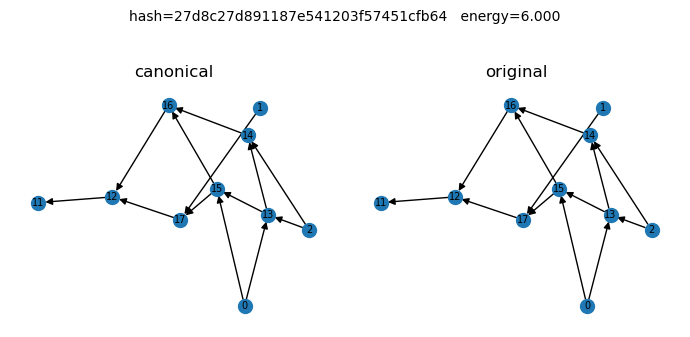

   2 │     6.0000 │ 75b4a0445a414912d8320849f2774e09 │    12


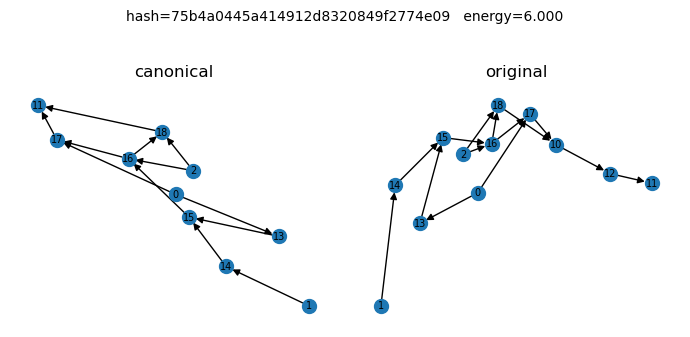

   3 │     6.0000 │ c0d9d84b41fe7c7e160c20514ba2ed9f │    12


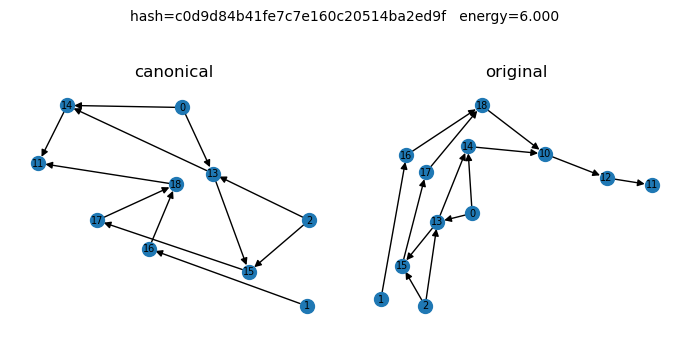

   4 │     6.0000 │ d83d67212aa362c36e1b70588c1a4c69 │    12


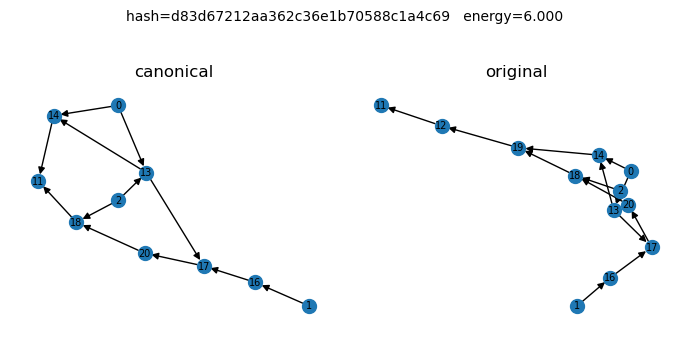

   5 │     6.0000 │ 37065d94b9436be837dac795b1a7ea03 │    10


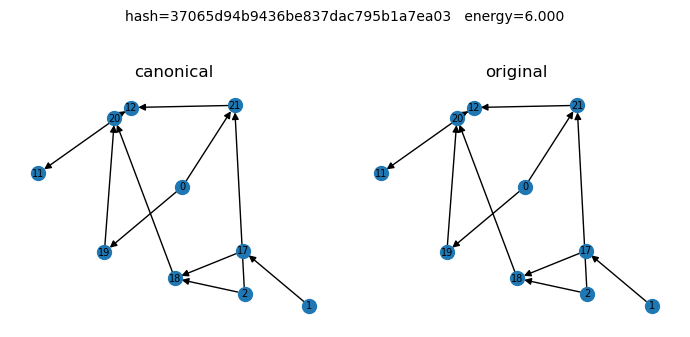

In [9]:
N = 5
top_lowest_energy_plots(registry, n=N)


Check if the top N graphs are isomorphic to one another

In [10]:
N = 20
iso_pairs_lowest(registry, top=N)

No canonical duplicates among the lowest 20 energies.


[]

Perform redundant edge removal, check for isomorphisms again, and adquire unique biological circuit designs

Optimal energy: 6.0000   raw count: 19
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
Stored canon = _apply_implicit_or(orig)
7 unique graph(s) remain after pruning + iso check.



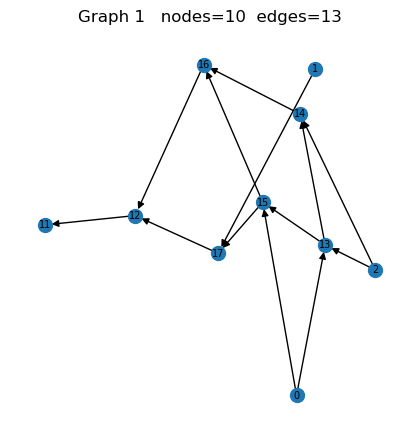

Truth table for Graph 1:
  (0, 0, 0)  →  0
  (0, 0, 1)  →  1
  (0, 1, 0)  →  0
  (0, 1, 1)  →  1
  (1, 0, 0)  →  0
  (1, 0, 1)  →  0
  (1, 1, 0)  →  1
  (1, 1, 1)  →  0



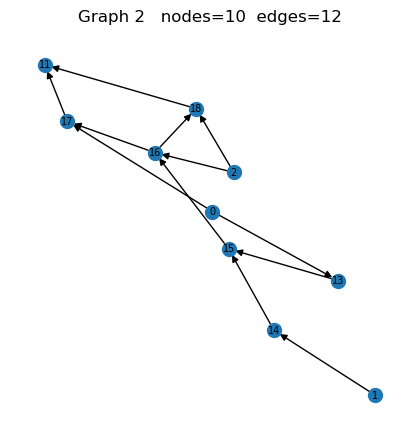

Truth table for Graph 2:
  (0, 0, 0)  →  0
  (0, 0, 1)  →  1
  (0, 1, 0)  →  0
  (0, 1, 1)  →  1
  (1, 0, 0)  →  0
  (1, 0, 1)  →  0
  (1, 1, 0)  →  1
  (1, 1, 1)  →  0



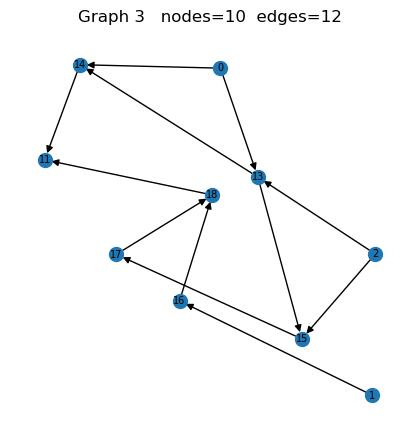

Truth table for Graph 3:
  (0, 0, 0)  →  0
  (0, 0, 1)  →  1
  (0, 1, 0)  →  0
  (0, 1, 1)  →  1
  (1, 0, 0)  →  0
  (1, 0, 1)  →  0
  (1, 1, 0)  →  1
  (1, 1, 1)  →  0



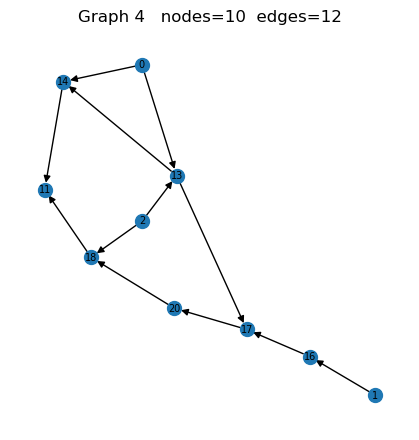

Truth table for Graph 4:
  (0, 0, 0)  →  0
  (0, 0, 1)  →  1
  (0, 1, 0)  →  0
  (0, 1, 1)  →  1
  (1, 0, 0)  →  0
  (1, 0, 1)  →  0
  (1, 1, 0)  →  1
  (1, 1, 1)  →  0



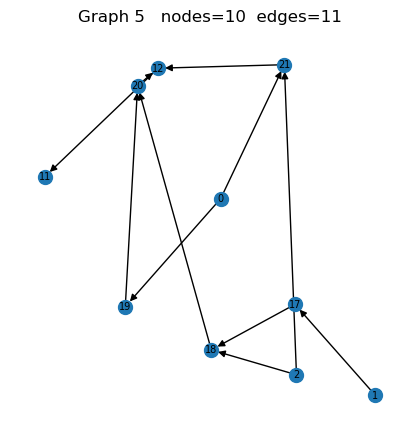

Truth table for Graph 5:
  (0, 0, 0)  →  0
  (0, 0, 1)  →  1
  (0, 1, 0)  →  0
  (0, 1, 1)  →  1
  (1, 0, 0)  →  0
  (1, 0, 1)  →  0
  (1, 1, 0)  →  1
  (1, 1, 1)  →  0



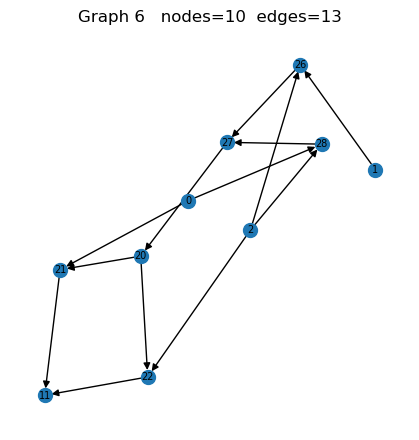

Truth table for Graph 6:
  (0, 0, 0)  →  0
  (0, 0, 1)  →  1
  (0, 1, 0)  →  0
  (0, 1, 1)  →  1
  (1, 0, 0)  →  0
  (1, 0, 1)  →  0
  (1, 1, 0)  →  1
  (1, 1, 1)  →  0



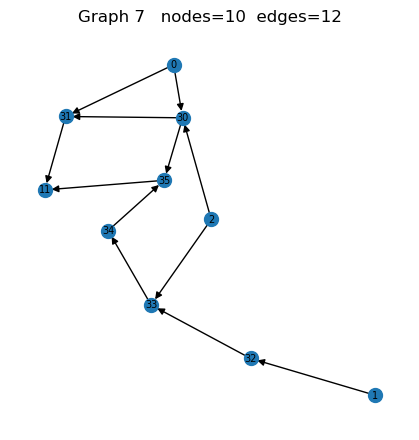

Truth table for Graph 7:
  (0, 0, 0)  →  0
  (0, 0, 1)  →  1
  (0, 1, 0)  →  0
  (0, 1, 1)  →  1
  (1, 0, 0)  →  0
  (1, 0, 1)  →  0
  (1, 1, 0)  →  1
  (1, 1, 1)  →  0



In [11]:
unique_graphs = prune_and_plot_optimal_v2(registry)

In [12]:
# 1) run both functions
res1 = prune_and_plot_optimal(registry, verbose=False)          # list[DiGraph]
res2 = prune_and_plot_optimal_v2(registry, verbose=False)       # list[DiGraph]

# 2) quick sanity-check: same cardinality
assert len(res1) == len(res2), "different number of graphs returned"

# 3) make sure every graph in res1 has an isomorphic twin in res2
for g in res1:
    if not any(nx.is_isomorphic(g, h) for h in res2):
        raise AssertionError("at least one graph in res1 is missing from res2")

# 4) and vice-versa (optional if you know res2 can’t contain extras)
for h in res2:
    if not any(nx.is_isomorphic(h, g) for g in res1):
        raise AssertionError("at least one graph in res2 is missing from res1")

print("Prune_and_plot_optimal and prune_and_plot_optimal_v2 give the same set of graphs")


Prune_and_plot_optimal and prune_and_plot_optimal_v2 give the same set of graphs


Validation of UNIQUE_GRAPHS and TTABLE_TO_ACTIONS

In [13]:
#validate_ttable_to_actions(UNIQUE_GRAPHS, TTABLE_TO_ACTIONS)

Check isomorphism to motif library

In [14]:
number_of_smallest_ML_circuits = len(unique_graphs)
number_of_smallest_ML_circuits

7

In [15]:
number_NOT_iso_to_motifs = check_vs_motif_bank(unique_graphs)
number_NOT_iso_to_motifs

Canonicalising motifs:   0%|          | 0/15928 [00:00<?, ?motif/s]

Built canonical bank for 15928 motifs.


Matching:   0%|          | 0/7 [00:00<?, ?graph/s]

Graph  1: MATCH   nodes=10  edges=13
Graph  2: NEW     nodes=10  edges=12
Graph  3: NEW     nodes=10  edges=12
Graph  4: NEW     nodes=10  edges=12
Graph  5: NEW     nodes=10  edges=11
Graph  6: NEW     nodes=10  edges=13
Graph  7: NEW     nodes=10  edges=12


6

In [16]:
number_NOT_iso_to_motifs_after_pruning = check_vs_motif_bank_pruned(unique_graphs)
number_NOT_iso_to_motifs_after_pruning

Canonicalising + pruning:   0%|          | 0/15928 [00:00<?, ?motif/s]

KeyboardInterrupt: 

Check the sizes of the seed graphs 

In [ ]:
log_file = run_dir / "selected_graphs.txt" 
energies_from_log_df = energies_from_log(str(log_file))

In [ ]:
initial_size_of_graph_hex =  energies_from_log_df.loc[0, 'truth_table_hex']
initial_size_of_graph = energies_from_log_df.loc[0, 'E_original']

In [ ]:
output_dir = run_dir / "optimal_topologies"
output_dir.mkdir(parents=True, exist_ok=True)
energies_from_log_df.to_csv(output_dir/"sizes_of_unoptimized_graphs_logged_in_selected_graphs.csv", index=False) 

Check the sizes of the motifs that can compute this logic function

In [ ]:
comparison = compare_to_motif_bank(unique_graphs, verbose = True, max_plots_per_key = 10,plotting = True)

pd.DataFrame(comparison).head()

In [ ]:
#print the attributes of the pre-computed motifs canonical 
test_graph = UNIQUE_GRAPHS_canonical[10]
for nodes in test_graph.nodes(data = True):
    print(nodes)


Double-check the sizes of the motifs that can compute this logic function using an alternative methods

In [ ]:
comparison2 = compare_to_motif_bank_simple(unique_graphs, verbose = True)

comparison2_df = pd.DataFrame(comparison2)

comparison2_df

In [ ]:
smallest_ML_size = comparison2_df.loc[0, 'ML_energy']
smallest_precomputed_motif = comparison2_df.loc[0, 'best_bank_energy']

In [ ]:
#comparison3 = compare_to_motif_bank_perm(unique_graphs, verbose = True)

#comparison3_df = pd.DataFrame(comparison3)

#comparison3_df

In [ ]:
df1 = pd.DataFrame(comparison)
df2 = pd.DataFrame(comparison2)

# Try to use comparison3 if it exists
try:
    df3 = pd.DataFrame(comparison3)
    all_three_methods_flag = True
except NameError:
    all_three_methods_flag = False

if all_three_methods_flag:
    # Check all three
    if not (df1.equals(df2) and df2.equals(df3)):
        raise ValueError("The methods to design the smallest circuit from the precomputed motifs do not give the same result.")
    print("All methods to design the smallest circuit from the precomputed motifs give the same result.")
else:
    # Only check the first two
    if not df1.equals(df2):
        raise ValueError("The methods to design the smallest circuit from the precomputed motifs do not give the same result.")
    print("Both available methods give the same result (comparison3 not defined).")


Save sizes of the motifs that can compute this logic function using an alternative method

In [ ]:
output_dir = run_dir / "optimal_topologies"
output_dir.mkdir(parents=True, exist_ok=True)

comparison2_df.to_csv(output_dir /"size_comparisons_to_action_motifs.csv", index=False)

Validation check comparing digital signal propagation and truth table 

In [ ]:
graph_to_check_inputs = unique_graphs[0]
input_nodes = [node for node in graph_to_check_inputs.nodes() if graph_to_check_inputs.in_degree(node) == 0]
num_inputs = len(input_nodes)
print(f"Number of inputs is {num_inputs}")

if num_inputs == 3:

    input_signals_list_binary = [
        {0: 0, 1: 0, 2: 0},  # First set of input signals
        {0: 0, 1: 0, 2: 1},  # Second set of input signals
        {0: 0, 1: 1, 2: 0},  # Third set of input signals
        {0: 0, 1: 1, 2: 1},  # First set of input signals
        {0: 1, 1: 0, 2: 0},  # Second set of input signals
        {0: 1, 1: 0, 2: 1},  # Third set of input signals    
        {0: 1, 1: 1, 2: 0},  # Second set of input signals
        {0: 1, 1: 1, 2: 1},  # Third set of input signals  
    ]   

elif num_inputs == 4:
    input_signals_list_binary = [
        {0: 0, 1: 0, 2: 0, 3: 0},  
        {0: 0, 1: 0, 2: 0, 3: 1},  
        {0: 0, 1: 0, 2: 1, 3: 0}, 
        {0: 0, 1: 0, 2: 1, 3: 1}, 
        {0: 0, 1: 1, 2: 0, 3: 0},  
        {0: 0, 1: 1, 2: 0, 3: 1},    
        {0: 0, 1: 1, 2: 1, 3: 0},  
        {0: 0, 1: 1, 2: 1, 3: 1}, 
        {0: 1, 1: 0, 2: 0, 3: 0},  
        {0: 1, 1: 0, 2: 0, 3: 1},  
        {0: 1, 1: 0, 2: 1, 3: 0}, 
        {0: 1, 1: 0, 2: 1, 3: 1}, 
        {0: 1, 1: 1, 2: 0, 3: 0},  
        {0: 1, 1: 1, 2: 0, 3: 1},    
        {0: 1, 1: 1, 2: 1, 3: 0},  
        {0: 1, 1: 1, 2: 1, 3: 1},     
]    

In [ ]:
sim_hex_all = []   # holds each sim_hex, in the same order as unique_graphs
tt_hex_all  = []   # holds each tt_hex,  likewise

for G_current in unique_graphs:
    # --- generate results ---------------------------------------------------
    sim_raw = simulate_signal_propagation_binary(G_current, input_signals_list_binary)
    tt_raw  = calculate_truth_table_v2(G_current)

    # --- flatten outputs, preserving original order -------------------------
    sim_outputs = [list(d.values())[0] for d in sim_raw]       # [{4: 0}, …] → [0, …]
    tt_outputs  = [v[0]              for v in tt_raw.values()] # {…:(0,), …} → [0, …]

    # --- basic length check -------------------------------------------------
    if len(sim_outputs) != len(tt_outputs):
        raise ValueError(
            f"Length mismatch: {len(sim_outputs)} simulation cases "
            f"vs {len(tt_outputs)} truth-table cases."
        )

    # --- bit-string → padded → hex (keeping leading zeros) ------------------
    sim_bits = ''.join(str(b) for b in sim_outputs)
    tt_bits  = ''.join(str(b) for b in tt_outputs)

    sim_bits_padded = sim_bits.zfill((len(sim_bits) + 3) // 4 * 4)
    tt_bits_padded  = tt_bits .zfill((len(tt_bits ) + 3) // 4 * 4)

    sim_hex_digits = len(sim_bits_padded) // 4
    tt_hex_digits  = len(tt_bits_padded) // 4

    sim_hex = '0x' + format(int(sim_bits_padded, 2), f'0{sim_hex_digits}X')
    tt_hex  = '0x' + format(int(tt_bits_padded , 2), f'0{tt_hex_digits}X')


    sim_hex_all.append(sim_hex)
    tt_hex_all.append(tt_hex)

    print(f"\nGraph {G_current}:")
    print(f"  Simulation outputs (hex):    {sim_hex}")
    print(f"  Truth-table outputs (hex):   {tt_hex}")

    # --- compare and report mismatches --------------------------------------
    all_match = True
    n_inputs  = len(next(iter(tt_raw)))        # number of input lines

    for idx, (s, t) in enumerate(zip(sim_outputs, tt_outputs)):
        if s != t:
            input_bits = tuple(int(b) for b in f"{idx:0{n_inputs}b}")
            print(f"  Input {input_bits}: simulation={s}, truth_table={t}")
            all_match = False

    if all_match:
        print("  Output patterns match.")
    else:
        print("  Finished comparison — mismatches listed above.")

Structural verification 

In [ ]:
for g_idx, G_current in enumerate(unique_graphs):
    result = validate_dag(G_current, 1, raise_on_error=True, plot_on_error=True)
    print(result)

Functional verification

In [ ]:
'''
def truth_table_impl_user(G, input_names, output_names):
    G2 = G.copy()
    for o in output_names:
        G2.nodes[o]['type'] = 'output'
    return calculate_truth_table_v2(G2)
'''

for g_idx, G_current in enumerate(unique_graphs):
    eq_folder = run_dir / "yosys_eqv" / f"graph_{g_idx:03d}"
    eq_folder.mkdir(parents=True, exist_ok=True)  # ensure path exists

    ok_tt = validate_tt_using_yosys(G_current, folder=eq_folder, verbose=True)
    print(ok_tt)
    if not ok_tt:
        raise AssertionError(
            f"[graph {g_idx:03d}] Truth-table mismatch. See {eq_folder}/truth.out and tt_*.json/txt."
        )

Verify all hex values are equivalent 

In [ ]:
verify_hex_consistency(
    sim_hex_all,
    tt_hex_all,
    initial_size_of_graph_hex,
    circuit_hex,
)

Compute and export truth table

In [ ]:
output_dir = run_dir / "optimal_topologies"
output_dir.mkdir(parents=True, exist_ok=True)

for g_idx, G_current in enumerate(unique_graphs):
    tt_folder = output_dir/ f"{initial_size_of_graph_hex}_optimal_topology_{g_idx}_tt"  # fixed quotes
    tt = calculate_truth_table_v2(G_current)
    write_tt_files(G_current, tt, tt_folder)

Determine the truth table using Yosys 

In [ ]:
for g_idx, G_current in enumerate(unique_graphs):
    yosys_tt_folder = run_dir / "yosys_tt" / f"{initial_size_of_graph_hex}_optimal_topology_{g_idx}_tt"
    combos, rows = yosys_truth_table_with_yosys(G_current, folder = yosys_tt_folder, verbose=True)
    in_names, out_names = infer_io(G_current)  # same inference the function uses
    write_tt_files_yosys(yosys_tt_folder, combos, rows, in_names, out_names)

Save optimal and unique biological circuit designs 

In [ ]:
output_dir = run_dir / "optimal_topologies"
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / "optimal_topologies.pkl", "wb") as f:
    pickle.dump(unique_graphs, f)

Plot and save circuit designs 

In [ ]:
#initial_size_of_graph_hex = "0x17"

In [ ]:
output_dir = run_dir / "optimal_topologies"
output_dir.mkdir(parents=True, exist_ok=True)

for g_idx, G_current in enumerate(unique_graphs):
    plot_circuit_layered(
        G_current,
        outdir=output_dir,
        name=f'{initial_size_of_graph_hex}_optimal_topology_{g_idx}',
        fmt="svg",                   # or "svg"
        rankdir="LR",
        show_in_notebook=True,      # important: allows gv_size to apply
        compact=True,
        gv_size="8,4.5!",            # inches; "!" forces exact scaling
        gv_dpi=None,                 # do NOT set dpi for vector export
        gv_margin="0.05",
        gv_pad="0.05"
    )

Summary

In [ ]:
print("----------------------------------------------------------------------")
print("Summary: ")
print(f"Initial graph hex:                      {initial_size_of_graph_hex}")
print(f"Initial graph size decimal:             {initial_size_of_graph}")

print(f"number_of_smallest_ML_circuits:         {number_of_smallest_ML_circuits}")
print(f"Non-isomorphic to motifs:               {number_NOT_iso_to_motifs}")
print(f"Non-isomorphic to motifs after pruning: {number_NOT_iso_to_motifs_after_pruning}")

print(f"Smallest ML size found:                 {smallest_ML_size}")
print(f"Smallest pre-computed motif size:       {smallest_precomputed_motif}")
print("----------------------------------------------------------------------")

In [ ]:
stop

Calculate edit distances among each other in the optimal and unique biological circuit designs

In [17]:
#Load optimal graph (optional if the code above was run)
from pathlib import Path
import pickle

output_dir = Path(run_dir) / "optimal_topologies"
pkl_path = output_dir / "optimal_topologies.pkl"

if not pkl_path.exists():
    raise FileNotFoundError(f"Missing file: {pkl_path}")

with open(pkl_path, "rb") as f:
    unique_graphs = pickle.load(f)

print(f"Loaded {len(unique_graphs)} graphs")

Loaded 7 graphs


In [18]:
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [ ]:
from tqdm.notebook import tqdm 
def graph_edit_distance_matrix(graphs, *, timeout=None):
    """
    Return an NxN symmetric matrix of pair-wise edit distances.
    Always shows a tqdm progress bar (one tick per graph pair).
    """
    n = len(graphs)
    if n == 0:
        raise ValueError("graphs is empty")

    dist   = np.zeros((n, n))
    pairs  = itertools.combinations(range(n), 2)
    total  = n * (n - 1) // 2              # number of distinct pairs

    print("total: ", total )
    for i, j in tqdm(pairs, total=total, desc="Graph-edit pairs", unit="pair"):
        #print("Calculating distance")
        d = nx.graph_edit_distance(graphs[i], graphs[j], timeout=timeout)

        # handle generator (≤ 2.6) or time-out (None)
        if d is None or not isinstance(d, (int, float)):
            try:
                d = min(d)
            except TypeError:
                d = float("inf")           

        dist[i, j] = dist[j, i] = d

    return dist

def edit_distance_heatmap_vector(
    graphs,
    *,
    timeout=None,
    ax=None,
    figsize=(6, 5),
    cmap="viridis",
    edgecolor="black",
    linewidth=0.5,
):
    """Vector (pcolormesh) heat-map ⇒ editable grid lines in SVG/PDF."""
    dist = graph_edit_distance_matrix(graphs, timeout=timeout)
    
    n = dist.shape[0]

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # pcolormesh: one QuadMesh cell per distance
    X, Y = np.meshgrid(np.arange(n + 1), np.arange(n + 1))
    pcm = ax.pcolormesh(
        X,
        Y,
        dist,
        cmap=cmap,
        edgecolors=edgecolor,
        linewidth=linewidth,
        shading="auto"
    )

    ax.set_aspect("equal")
    ax.set_xlabel("Graph index")
    ax.set_ylabel("Graph index")

    return dist, pcm, fig

In [ ]:
pt_to_in = lambda pt: pt / 270

# 1) high-DPI figure
fig, ax = plt.subplots(figsize=(pt_to_in(500), pt_to_in(300)), dpi=150)

# 2) editable vector heat-map (no y-axis inversion)
dist, pcm, _ = edit_distance_heatmap_vector(
    unique_graphs,
    ax=ax,
    cmap="Blues",
    edgecolor="black",
    linewidth=0.25,
    timeout=None,
)

# 3) colour-bar
cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)

# 4) tidy ticks and labels ──────────────
n = dist.shape[0]          # square → n × n

ax.set_xticks(np.arange(n) + 0.5)
ax.set_yticks(np.arange(n) + 0.5)
ax.set_xticklabels(np.arange(n), fontsize=6)
ax.set_yticklabels(np.arange(n), fontsize=6)
ax.tick_params(axis="both", length=0, width=0.5, labelsize=6)

ax.set_xlabel("Graph index", fontsize=6)
ax.set_ylabel("Graph index", fontsize=6)
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# colour-bar cosmetics
cbar.set_label("Graph edit distance", fontsize=6)
cbar.ax.tick_params(labelsize=6, width=0.5)
cbar.outline.set_linewidth(0.5)


vmin, vmax = pcm.norm.vmin, pcm.norm.vmax 
ticks = np.arange(np.floor(vmin), np.ceil(vmax) + 1, 1)
cbar.set_ticks(ticks)
cbar.formatter = FormatStrFormatter('%d')  # show as integers
cbar.update_normal(pcm)  # ensure formatter/ticks apply

# Make those major tick marks thick/long
cbar.ax.tick_params(which="major", width=0.5, length=3, labelsize=6)

fig.subplots_adjust(left=0.18, bottom=0.18, right=0.88)  # keep bar visible
plt.show()

In [ ]:
out_file = output_dir / "edit_distance_to_other_ML_designs_heatmap.svg"   # Path object

fig.savefig(
    out_file,     # .svg (vector) or .pdf both work well
    format="svg",                    # choose format from extension
    dpi=300,                         # irrelevant for SVG/PDF but fine for .png
    bbox_inches="tight"              # crop to the actual drawing
)
plt.close(fig)

out_file

In [ ]:
#save raw data

n = dist.shape[0]
labels = [str(i) for i in range(n)]  # 0..n-1

df = pd.DataFrame(dist, index=labels, columns=labels)
df.to_csv(
    output_dir / "edit_distance_to_other_ML_designs_heatmap.csv",
    float_format="%.6g",
    index=True,              # included by default, but explicit is nice
    header=True,
    index_label="graph_index"
)

Calculate distances to motifs (cannonical, double-check it is good) from the optimal and unique biological circuit designs

In [19]:
# Distance matrix  (inline safety checks, no helper function)
def bank_edit_distance_matrix(
    unique_graphs,
    *,
    timeout=None,
    same_energy_only=True,
):
    """
    Return an NxM matrix of edit distances (graph_edit_distance) from
    *unique_graphs* to bank motifs that share the same truth-table key.

    If `same_energy_only=True` (default) keep only bank motifs whose energy
    exactly matches one of the candidate energies.  When the filter removes
    every motif, print a note and return (None, []).
    """
    if not unique_graphs:
        raise ValueError("unique_graphs is empty")

    ref_key = _compute_truth_key(unique_graphs[0])
    if any(_compute_truth_key(g) != ref_key for g in unique_graphs[1:]):
        raise ValueError("All graphs must share the same truth-table key")

    all_bank_idxs = TTABLE_TO_ACTIONS.get(ref_key, [])
    if not all_bank_idxs:
        print(f"No bank motifs found for key {ref_key}.")
        return None, []

    # energies of the candidate graphs
    cand_E = {
        energy_score(g, check_implicit_OR_existence_v3)[0] for g in unique_graphs
    }

    # optional energy filter
    if same_energy_only:
        bank_idxs = [
            j for j in all_bank_idxs
            if energy_score(UNIQUE_GRAPHS[j],
                            check_implicit_OR_existence_v3)[0] in cand_E
        ]
        if not bank_idxs:
            print(f"Energy filter removed all bank motifs for key "
                  f"{ref_key}.  Nothing to compare.\n")
            return None, []
    else:
        bank_idxs = all_bank_idxs

    bank_graphs = [UNIQUE_GRAPHS[j] for j in bank_idxs]
    
    bank_graphs_cannon = [_apply_implicit_or(bank_graph) for bank_graph in bank_graphs]
    
    n, m = len(unique_graphs), len(bank_graphs_cannon)
    dist  = np.zeros((n, m))                     # <-- was missing

    # pair-wise edit distances with inline “safe” handling
    for i, g1 in enumerate(tqdm(unique_graphs, desc="Candidates", unit="graph")):
        for j, g2 in enumerate(bank_graphs_cannon):
            d = nx.graph_edit_distance(g1, g2, timeout=timeout)
            if d is None or not isinstance(d, (int, float)):
                try:
                    d = min(d)
                except TypeError:
                    d = float("inf")
            dist[i, j] = d

    return dist, bank_idxs


# ------------------------------------------------------------------
# 2) Editable vector heat-map  (stops cleanly if dist is None)
# ------------------------------------------------------------------
def bank_edit_distance_heatmap_vector(
    unique_graphs,
    *,
    timeout=None,
    same_energy_only=True,
    ax=None,
    figsize=(7, 5),
    cmap="viridis",
    edgecolor="black",
    linewidth=0.25,
    show=True,
):
    """
    Vector (pcolormesh) heat-map of candidate → bank edit distances.

    • Grid lines are editable in exported SVG/PDF.  
    • If the energy filter removes every motif the function just returns
      (None, [], None, None) without drawing.
    """
    dist, bank_idxs = bank_edit_distance_matrix(
        unique_graphs,
        timeout=timeout,
        same_energy_only=same_energy_only,
    )
    if dist is None:          # energy filter removed everything
        return None, [], None, None

    n, m = dist.shape
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    X, Y = np.meshgrid(np.arange(m + 1), np.arange(n + 1))
    pcm = ax.pcolormesh(
        X, Y, dist,
        cmap=cmap,
        edgecolors=edgecolor,
        linewidth=linewidth,
        shading="auto",
    )

    ax.set_xticks(np.arange(m) + 0.5)
    ax.set_xticklabels(bank_idxs, rotation=90, fontsize=6)
    ax.set_yticks(np.arange(n) + 0.5)
    ax.set_yticklabels(np.arange(n), fontsize=6)
    ax.tick_params(axis="both", length=0)
    ax.set_aspect("equal")

    #cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
    #cbar.set_label("Edit distance", fontsize=6)
    #cbar.ax.tick_params(labelsize=6)

    if show:
        plt.show()

    return dist, bank_idxs, fig, pcm


Candidates:   0%|          | 0/7 [00:00<?, ?graph/s]

/state/partition1/slurm_tmp/3487031.0.0/ipykernel_2185028/2155033692.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f"{t:.1f}" for t in cbar.get_ticks()])


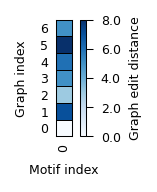

In [24]:
pt_to_in = lambda pt: pt / 270

fig, ax = plt.subplots(figsize=(pt_to_in(500), pt_to_in(300)), dpi=150)

dist, _, _, pcm = bank_edit_distance_heatmap_vector(
    unique_graphs,
    ax=ax,
    cmap="Blues",
    edgecolor="black",
    linewidth=0.25,
    timeout=None,
    show=False,                 
)

if dist is not None:
    
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)

    # ── custom styling (unchanged) ─────────────────────────────────────────
    n, m = dist.shape
    ax.set_xticks(np.arange(m) + 0.5)
    ax.set_yticks(np.arange(n) + 0.5)
    ax.set_xticklabels(np.arange(m), fontsize=6)
    ax.set_yticklabels(np.arange(n), fontsize=6)
    ax.tick_params(axis="both", length=0, width=0.5, labelsize=6)

    ax.set_xlabel("Motif index", fontsize=6, labelpad=6)
    ax.set_ylabel("Graph index", fontsize=6, labelpad=6)
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    pcm.set_clim(vmin=0, vmax=np.nanmax(dist))

    cbar.set_label("Graph edit distance")
    cbar.ax.yaxis.label.set_size(6)
    cbar.ax.tick_params(labelsize=6, width=0.5)
    cbar.outline.set_linewidth(0.5)
    cbar.ax.set_yticklabels([f"{t:.1f}" for t in cbar.get_ticks()])

    fig.subplots_adjust(left=0.18, bottom=0.18)   


    plt.show()


In [25]:
dist

array([[0.],
       [7.],
       [3.],
       [5.],
       [6.],
       [8.],
       [5.]])

In [26]:
out_file = output_dir / "edit_distance_to_motifs_heatmap.svg"   # Path object

fig.savefig(
    out_file,     # .svg (vector) or .pdf both work well
    format="svg",                    # choose format from extension
    dpi=300,                         # irrelevant for SVG/PDF but fine for .png
    bbox_inches="tight"              # crop to the actual drawing
)
plt.close(fig) 

out_file

PosixPath('/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/Figures/Figure 2/Diversity panels/Notebook analysis/0x52/seed_1/optimal_topologies/edit_distance_to_motifs_heatmap.svg')

In [27]:
#save raw data

arr = np.asarray(dist, dtype=float)

# Labels: handle rectangular matrices too
n_rows, n_cols = arr.shape
row_labels = [str(i) for i in range(n_rows)]
col_labels = [str(i) for i in range(n_cols)]

df = pd.DataFrame(arr, index=row_labels, columns=col_labels)
df.index.name = "graph_index"      # first column name in CSV
df.columns.name = "motif_index"    # header label row (nice to have)

# 3) Ensure output dir exists
output_dir = Path(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

# 4) Write CSV
csv_path = output_dir / "edit_distance_to_motifs_heatmap.csv"
df.to_csv(csv_path, float_format="%.6g", index=True, header=True)

## Below is the code with upperbound 

Calculate __ distance among each other

In [ ]:
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.auto import tqdm

# ──────────────────────────────────────────────────────────
# 1) pair-wise edit-distance matrix
# ──────────────────────────────────────────────────────────
def graph_edit_distance_matrix_upper_bound(graphs, *, timeout=None, upper_bound=5):
    """
    Return an N×N symmetric matrix of pair-wise graph-edit distances.
    Missing / non-finite distances are stored as NaN.
    """
    n = len(graphs)
    if n == 0:
        raise ValueError("graphs is empty")

    # pre-fill with NaNs so the dtype is float and invalid values are masked later
    dist = np.full((n, n), np.nan, dtype=float)

    pairs  = itertools.combinations(range(n), 2)
    total  = n * (n - 1) // 2

    for i, j in tqdm(pairs, total=total, desc="Graph-edit pairs", unit="pair"):
        d = nx.graph_edit_distance(
            graphs[i], graphs[j], timeout=timeout, upper_bound=upper_bound
        )

        # convert None / inf / -inf to NaN
        if d is None or not np.isfinite(d):
            d = np.nan

        dist[i, j] = dist[j, i] = d

    np.fill_diagonal(dist, 0.0)      # self-distance is zero
    return dist


# ──────────────────────────────────────────────────────────
# 2) heat-map helper
# ──────────────────────────────────────────────────────────
def edit_distance_heatmap_vector_upper_bound(
    graphs,
    *,
    timeout=None,
    upper_bound=5,
    ax=None,
    figsize=(6, 5),
    cmap="viridis",          # any “normal” Matplotlib colormap
    nan_color="#92dc8c",     # light-grey for NaNs
    edgecolor="black",
    linewidth=0.5,
):
    dist = graph_edit_distance_matrix_upper_bound(
        graphs, timeout=timeout, upper_bound=upper_bound
    )

    # ── build a masked array so NaNs are hidden from the normal scaler
    dist_masked = np.ma.masked_invalid(dist)

    # ── copy the requested colormap and paint NaNs light-grey
    cmap_obj = mpl.cm.get_cmap(cmap).copy()
    cmap_obj.set_bad(nan_color)

    # ── linear (normal) scaling between min & max finite values
    vmin = np.nanmin(dist)
    vmax = np.nanmax(dist)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    n = dist.shape[0]
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    X, Y = np.meshgrid(np.arange(n + 1), np.arange(n + 1))
    pcm = ax.pcolormesh(
        X, Y, dist_masked,
        cmap=cmap_obj,
        norm=norm,
        edgecolors=edgecolor,
        linewidth=linewidth,
        shading="auto",
    )

    ax.set_aspect("equal")
    ax.set_xlabel("Graph index")
    ax.set_ylabel("Graph index")

    return dist, pcm, fig


In [ ]:
pt_to_in = lambda pt: pt / 270
upper_bound = 3

fig, ax = plt.subplots(figsize=(pt_to_in(500), pt_to_in(300)), dpi=150)

# 2) editable vector heat-map (no y-axis inversion)
dist, pcm, _ = edit_distance_heatmap_vector_upper_bound(
    unique_graphs,
    ax=ax,
    upper_bound = upper_bound,
    cmap="Blues",
    edgecolor="black",
    linewidth=0.25,
    timeout=None,
)

# 3) colour-bar
cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)

# 4) tidy ticks and labels ──────────────
n = dist.shape[0]          # square → n × n

ax.set_xticks(np.arange(n) + 0.5)
ax.set_yticks(np.arange(n) + 0.5)
ax.set_xticklabels(np.arange(n), fontsize=6)
ax.set_yticklabels(np.arange(n), fontsize=6)
ax.tick_params(axis="both", length=0, width=0.5, labelsize=6)

ax.set_xlabel("Graph index", fontsize=6)
ax.set_ylabel("Graph index", fontsize=6)
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# colour-bar cosmetics
cbar.set_label("Graph edit distance", fontsize=6)
cbar.ax.tick_params(labelsize=6, width=0.5)
cbar.outline.set_linewidth(0.5)

fig.subplots_adjust(left=0.18, bottom=0.18, right=0.88)  # keep bar visible
plt.show()


In [ ]:
dist

In [ ]:
out_file = output_dir / f"edit_distance_to_other_ML_designs_heatmap_upperbound{upper_bound}.svg"   # Path object

fig.savefig(
    out_file,     # .svg (vector) or .pdf both work well
    format="svg",                    # choose format from extension
    dpi=300,                         # irrelevant for SVG/PDF but fine for .png
    bbox_inches="tight"              # crop to the actual drawing
)
plt.close(fig)

out_file

Calculate __ distance to motifs (double-check this)

In [ ]:
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.auto import tqdm

# ─────────────────────────────────────────────────────────────
# 1) Distance matrix  (upper-bound + NaN handling)
# ─────────────────────────────────────────────────────────────
def bank_edit_distance_matrix_upper_bound(
    unique_graphs,
    *,
    timeout=None,
    same_energy_only=True,
    upper_bound=5,                     # NEW
):
    """
    Return an N×M matrix of edit distances from *unique_graphs*
    to bank motifs sharing the same truth-table key.

    • Distances that time-out / exceed the upper-bound / are non-finite
      are stored as NaN so they can be masked later.
    """
    if not unique_graphs:
        raise ValueError("unique_graphs is empty")

    ref_key = _compute_truth_key(unique_graphs[0])
    if any(_compute_truth_key(g) != ref_key for g in unique_graphs[1:]):
        raise ValueError("All graphs must share the same truth-table key")

    all_bank_idxs = TTABLE_TO_ACTIONS.get(ref_key, [])
    if not all_bank_idxs:
        print(f"No bank motifs found for key {ref_key}.")
        return None, []

    # energies of the candidate graphs
    cand_E = {
        energy_score(g, check_implicit_OR_existence_v3)[0] for g in unique_graphs
    }

    # optional energy filter
    if same_energy_only:
        bank_idxs = [
            j for j in all_bank_idxs
            if energy_score(
                UNIQUE_GRAPHS[j], check_implicit_OR_existence_v3
            )[0] in cand_E
        ]
        if not bank_idxs:
            print(
                f"Energy filter removed all bank motifs for key {ref_key}. "
                "Nothing to compare.\n"
            )
            return None, []
    else:
        bank_idxs = all_bank_idxs

    bank_graphs = [UNIQUE_GRAPHS[j] for j in bank_idxs]

    n, m = len(unique_graphs), len(bank_graphs)
    dist = np.full((n, m), np.nan, dtype=float)  # pre-fill with NaNs

    # pair-wise edit distances (upper-bound + safe NaN conversion)
    for i, g1 in enumerate(tqdm(unique_graphs, desc="Candidates", unit="graph")):
        for j, g2 in enumerate(bank_graphs):
            d = nx.graph_edit_distance(
                g1, g2, timeout=timeout, upper_bound=upper_bound
            )
            if d is None or not np.isfinite(d):
                d = np.nan
            dist[i, j] = d

    return dist, bank_idxs


# ─────────────────────────────────────────────────────────────
# 2) Vector heat-map  (masked NaNs → light-grey)
# ─────────────────────────────────────────────────────────────
def bank_edit_distance_heatmap_vector_upper_bound(
    unique_graphs,
    *,
    timeout=None,
    same_energy_only=True,
    upper_bound=5,                     # NEW
    ax=None,
    figsize=(7, 5),
    cmap="viridis",
    nan_color="#fbffce",               # NEW
    edgecolor="black",
    linewidth=0.25,
    show=True,
):
    """
    Vector (pcolormesh) heat-map of candidate → bank edit distances.
    NaNs are shown in *nan_color*; finite distances use *cmap*.
    """
    dist, bank_idxs = bank_edit_distance_matrix_upper_bound(
        unique_graphs,
        timeout=timeout,
        same_energy_only=same_energy_only,
        upper_bound=upper_bound,
    )
    if dist is None:              # energy filter removed everything
        return None, [], None, None

    # ── build a masked array so NaNs are hidden from the normal scaler
    dist_masked = np.ma.masked_invalid(dist)

    # ── copy the requested colormap and paint NaNs light-grey
    cmap_obj = mpl.cm.get_cmap(cmap).copy()
    cmap_obj.set_bad(nan_color)

    # ── linear (normal) scaling across *finite* values
    finite_vals = dist[np.isfinite(dist)]
    if finite_vals.size == 0:
        vmin, vmax = 0.0, 1.0     # arbitrary fallback
    else:
        vmin, vmax = finite_vals.min(), finite_vals.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    n, m = dist.shape
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    X, Y = np.meshgrid(np.arange(m + 1), np.arange(n + 1))
    pcm = ax.pcolormesh(
        X, Y, dist_masked,
        cmap=cmap_obj,
        norm=norm,
        edgecolors=edgecolor,
        linewidth=linewidth,
        shading="auto",
    )

    # axis cosmetics (unchanged)
    ax.set_xticks(np.arange(m) + 0.5)
    ax.set_xticklabels(bank_idxs, rotation=90, fontsize=6)
    ax.set_yticks(np.arange(n) + 0.5)
    ax.set_yticklabels(np.arange(n), fontsize=6)
    ax.tick_params(axis="both", length=0)
    ax.set_aspect("equal")

    if show:
        cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Edit distance", fontsize=6)
        cbar.ax.tick_params(labelsize=6)

    return dist, bank_idxs, fig, pcm



In [ ]:
upper_bound = 2

pt_to_in = lambda pt: pt / 270

fig, ax = plt.subplots(figsize=(pt_to_in(500), pt_to_in(300)), dpi=150)

dist, _, _, pcm = bank_edit_distance_heatmap_vector_upper_bound(
    unique_graphs,
    ax=ax,
    cmap="Blues",
    upper_bound=upper_bound,          # <── just add/adjust this
    edgecolor="black",
    linewidth=0.25,
    timeout=None,
    show=False,
)

if dist is not None:
    
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)

    # ── custom styling (unchanged) ─────────────────────────────────────────
    n, m = dist.shape
    ax.set_xticks(np.arange(m) + 0.5)
    ax.set_yticks(np.arange(n) + 0.5)
    ax.set_xticklabels(np.arange(m), fontsize=6)
    ax.set_yticklabels(np.arange(n), fontsize=6)
    ax.tick_params(axis="both", length=0, width=0.5, labelsize=6)

    ax.set_xlabel("Motif index", fontsize=6, labelpad=6)
    ax.set_ylabel("Graph index", fontsize=6, labelpad=6)
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    pcm.set_clim(vmin=0, vmax=np.nanmax(dist))

    cbar.set_label("Graph edit distance")
    cbar.ax.yaxis.label.set_size(6)
    cbar.ax.tick_params(labelsize=6, width=0.5)
    cbar.outline.set_linewidth(0.5)
    cbar.ax.set_yticklabels([f"{t:.1f}" for t in cbar.get_ticks()])

    fig.subplots_adjust(left=0.18, bottom=0.18)   


    plt.show()


In [ ]:
out_file = output_dir / f"edit_distance_to_other_ML_designs_heatmap_upperbound{upper_bound}.svg"   # Path object

fig.savefig(
    out_file,     # .svg (vector) or .pdf both work well
    format="svg",                    # choose format from extension
    dpi=300,                         # irrelevant for SVG/PDF but fine for .png
    bbox_inches="tight"              # crop to the actual drawing
)
plt.close(fig)

out_file